In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import os
from glob import glob
from PIL import Image  # Make sure to import this for image loading

In [2]:
class RoutePlotsDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_name).convert("L")  # Convert to grayscale
        
        if self.transform:
            image = self.transform(image)
        
        return image, self.image_files[idx]  # Return image and filename


In [3]:
image_size = 600
# Create a transform to resize the images to 28x28
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize to 28x28
    transforms.ToTensor(),  # Convert to Tensor
])

# Load your dataset from the folder
folder_path = 'route_plots'  # Adjust to your folder
route_dataset = RoutePlotsDataset(folder_path, transform=transform)

# Create DataLoader
batch_size = 10
train_loader = DataLoader(dataset=route_dataset, batch_size=batch_size, shuffle=True)

data_dim = image_size*image_size

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
class VAE(nn.Module):

    def __init__(self, input_dim=data_dim, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()
        
        self.device = device #newly added

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)
        
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.decode(z)  
        return x_hat, mean, log_var

In [6]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [7]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [8]:

def train_in_segments(model, optimizer, train_loader, device, segment_size, epochs_per_segment=1):
    """
    Train the model in segments of data to manage memory and improve training efficiency.

    Args:
        model (torch.nn.Module): The model to train.
        optimizer (torch.optim.Optimizer): Optimizer for model training.
        train_loader (DataLoader): DataLoader for the full training data.
        device (torch.device): Device to train on (CPU or GPU).
        segment_size (int): Number of batches per segment.
        epochs_per_segment (int): Number of epochs to train on each segment before moving to the next.
    """
    model.train()
    dataset_len = len(train_loader)
    segment_count = (dataset_len // segment_size) + (1 if dataset_len % segment_size != 0 else 0)

    for segment_idx in range(segment_count):
        print(f"Training on segment {segment_idx + 1}/{segment_count}")

        # Limit the data loader to the current segment
        segment_data = list(train_loader)[segment_idx * segment_size:(segment_idx + 1) * segment_size]

        for epoch in range(epochs_per_segment):
            segment_loss = 0
            for batch_idx, (x, _) in enumerate(segment_data):
                x = x.view(x.size(0), -1).to(device)  # Flatten the input and send to device

                optimizer.zero_grad()
                x_hat, mean, log_var = model(x)
                loss = loss_function(x, x_hat, mean, log_var)

                segment_loss += loss.item()
                loss.backward()
                optimizer.step()

            print(f"  Epoch {epoch + 1}/{epochs_per_segment} - Average Loss: {segment_loss / len(segment_data)}")

# Example usage:
# Assuming the rest of your setup (model, optimizer, train_loader, device) is already defined
segment_size = 200  # Number of batches per segment
train_in_segments(model, optimizer, train_loader, device, segment_size, epochs_per_segment=2)


Training on segment 1/17
  Epoch 1/2 - Average Loss: 125318.81741210938
  Epoch 2/2 - Average Loss: 20454.11979003906
Training on segment 2/17
  Epoch 1/2 - Average Loss: 18728.269638671874
  Epoch 2/2 - Average Loss: 17768.58271484375
Training on segment 3/17
  Epoch 1/2 - Average Loss: 17263.658232421876
  Epoch 2/2 - Average Loss: 16654.972978515623
Training on segment 4/17
  Epoch 1/2 - Average Loss: 16432.55845703125
  Epoch 2/2 - Average Loss: 16036.690229492187
Training on segment 5/17
  Epoch 1/2 - Average Loss: 16012.79314453125
  Epoch 2/2 - Average Loss: 15641.407133789062
Training on segment 6/17
  Epoch 1/2 - Average Loss: 15536.786411132813
  Epoch 2/2 - Average Loss: 15144.186694335938
Training on segment 7/17
  Epoch 1/2 - Average Loss: 15107.463051757812
  Epoch 2/2 - Average Loss: 14771.459521484376
Training on segment 8/17
  Epoch 1/2 - Average Loss: 14779.162939453125
  Epoch 2/2 - Average Loss: 14528.6755859375
Training on segment 9/17
  Epoch 1/2 - Average Loss: 1

In [15]:
import os

# Directory to save the model
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

# File name for the model
model_path = os.path.join(save_dir, "vae_model_segmented.pth")

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to saved_models\vae_model_segmented.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


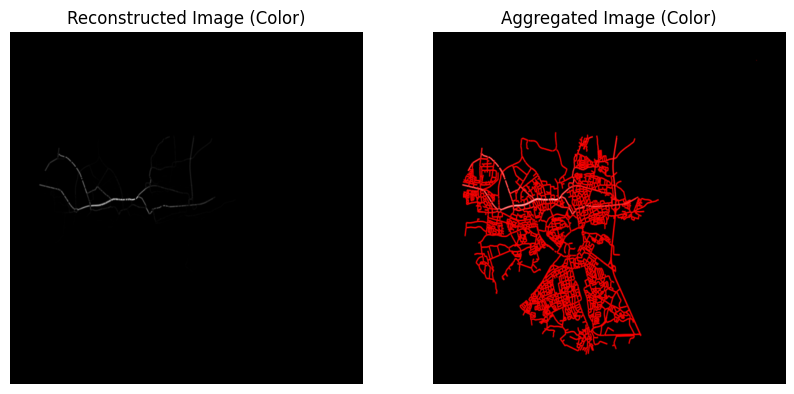

Aggregated image saved at aggregated_images\aggregated_image_1.png


In [11]:
import random

# Load and prepare the map_plot image as a tensor
map_plot_path = 'map_plot/map_plot.png'

# Load the map_plot image in RGB (color)
map_plot_image = Image.open(map_plot_path).convert('RGB')  # Preserve color
map_plot_tensor = transforms.ToTensor()(map_plot_image)
map_plot_tensor = transforms.Resize((image_size, image_size))(map_plot_tensor)

from PIL import Image
import os

def plot_and_save_aggregated_image(model, dataset, map_plot_tensor, image_index=None, save_path='aggregated_images'):
    """
    Plot the reconstructed image and its multiplication with map_plot in color,
    then save the multiplied image to a specified folder.
    """
    model.eval()

    # Select a random index if not provided
    if image_index is None:
        image_index = random.randint(0, len(dataset) - 1)

    # Retrieve and preprocess the image
    img, _ = dataset[image_index]
    img = img.view(1, -1).to(device)

    # Reconstruct the image using the VAE
    with torch.no_grad():
        reconstructed_img, _, _ = model(img)

    # Reshape the reconstructed image to RGB
    reconstructed_img_np = reconstructed_img.view(image_size, image_size).cpu().numpy()
    reconstructed_img_rgb = np.stack([reconstructed_img_np] * 3, axis=-1)  # Duplicate channels for RGB

    # Convert the map_plot to a numpy array
    map_plot_np = map_plot_tensor.permute(1, 2, 0).cpu().numpy()

    # Multiply each channel independently
    multiplied_result = reconstructed_img_rgb + map_plot_np

    # Plot the reconstructed and multiplied images side-by-side in color
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Reconstructed Image in Color
    axes[0].imshow(reconstructed_img_rgb)
    axes[0].axis('off')
    axes[0].set_title("Reconstructed Image (Color)")

    # Multiplied Image in Color
    axes[1].imshow(multiplied_result)
    axes[1].axis('off')
    axes[1].set_title("Aggregated Image (Color)")

    plt.show()

    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)

    # Save the multiplied image
    multiplied_image = Image.fromarray((multiplied_result * 255).astype(np.uint8))
    multiplied_image_path = os.path.join(save_path, f'aggregated_image_{image_index}.png')
    multiplied_image.save(multiplied_image_path)
    print(f"Aggregated image saved at {multiplied_image_path}")

# Use the function
plot_and_save_aggregated_image(model, route_dataset, map_plot_tensor, image_index=1)

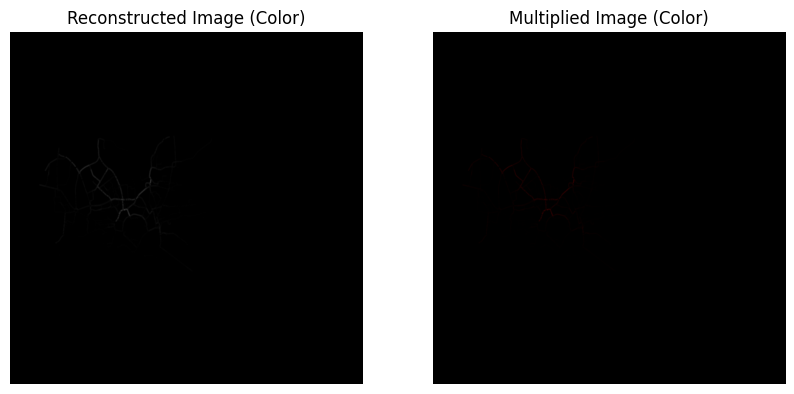

Multiplied image saved at multiplied_images\multiplied_image_5.png


In [32]:
from PIL import Image
import os

def plot_and_save_multiplied_image(model, dataset, map_plot_tensor, image_index=None, save_path='multiplied_images'):
    """
    Plot the reconstructed image and its multiplication with map_plot in color,
    then save the multiplied image to a specified folder.
    """
    model.eval()

    # Select a random index if not provided
    if image_index is None:
        image_index = random.randint(0, len(dataset) - 1)

    # Retrieve and preprocess the image
    img, _ = dataset[image_index]
    img = img.view(1, -1).to(device)

    # Reconstruct the image using the VAE
    with torch.no_grad():
        reconstructed_img, _, _ = model(img)

    # Reshape the reconstructed image to RGB
    reconstructed_img_np = reconstructed_img.view(image_size, image_size).cpu().numpy()
    reconstructed_img_rgb = np.stack([reconstructed_img_np] * 3, axis=-1)  # Duplicate channels for RGB

    # Convert the map_plot to a numpy array
    map_plot_np = map_plot_tensor.permute(1, 2, 0).cpu().numpy()

    # Multiply each channel independently
    multiplied_result = reconstructed_img_rgb * map_plot_np

    # Plot the reconstructed and multiplied images side-by-side in color
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Reconstructed Image in Color
    axes[0].imshow(reconstructed_img_rgb)
    axes[0].axis('off')
    axes[0].set_title("Reconstructed Image (Color)")

    # Multiplied Image in Color
    axes[1].imshow(multiplied_result)
    axes[1].axis('off')
    axes[1].set_title("Multiplied Image (Color)")

    plt.show()

    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)

    # Save the multiplied image
    multiplied_image = Image.fromarray((multiplied_result * 255).astype(np.uint8))
    multiplied_image_path = os.path.join(save_path, f'multiplied_image_{image_index}.png')
    multiplied_image.save(multiplied_image_path)
    print(f"Multiplied image saved at {multiplied_image_path}")

# Use the function
plot_and_save_multiplied_image(model, route_dataset, map_plot_tensor, image_index=5)

In [17]:
import numpy as np
import torch

def threshold_white_pixels(reconstructed_img, threshold=0.5):
    """
    Removes pixels that are not white enough from a reconstructed image based on a threshold.

    Args:
        reconstructed_img (torch.Tensor or np.ndarray): The input reconstructed image (2D array).
        threshold (float): Threshold between 0 and 1 to consider a pixel as "white enough".

    Returns:
        np.ndarray: The processed image with only "white enough" pixels retained.
    """
    # Ensure the image is a NumPy array
    if isinstance(reconstructed_img, torch.Tensor):
        reconstructed_img = reconstructed_img.cpu().numpy()
    
    # Apply the threshold
    processed_img = np.where(reconstructed_img > threshold, 1.0, 0.0)

    return processed_img


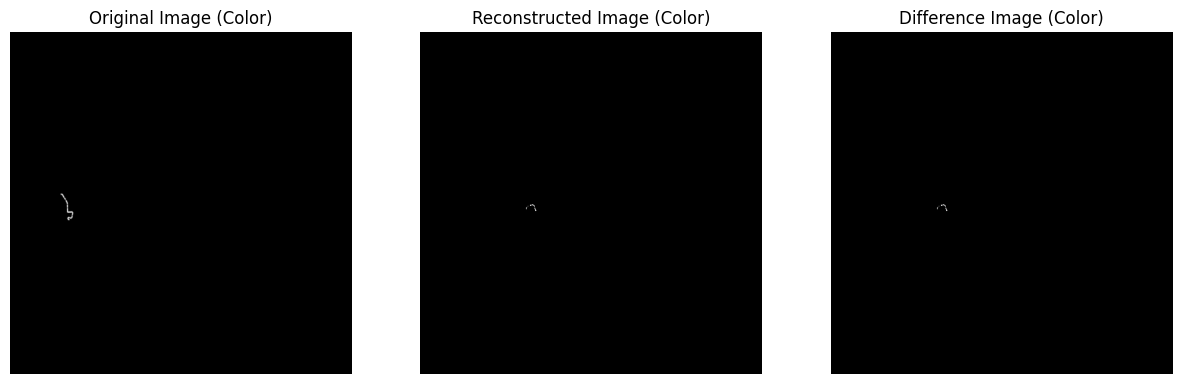

Difference image saved at difference_images\difference_image_5.png
Percentage of white pixels preserved: 0.00%


In [31]:
def plot_and_save_difference_image_with_metrics(model, dataset, map_plot_tensor, image_index=None, save_path='difference_images'):
    """
    Plot the original, reconstructed, and difference images in color,
    measure the numerical difference, and then save the difference image to a specified folder.
    """
    model.eval()

    # Select a random index if not provided
    if image_index is None:
        image_index = random.randint(0, len(dataset) - 1)

    # Retrieve and preprocess the image
    original_img, _ = dataset[image_index]
    original_img = original_img.view(1, -1).to(device)

    # Reconstruct the image using the VAE
    with torch.no_grad():
        reconstructed_img, _, _ = model(original_img)

    # Reshape the original and reconstructed images
    original_img_np = original_img.view(image_size, image_size).cpu().numpy()
    reconstructed_img_np = reconstructed_img.view(image_size, image_size).cpu().numpy()
    
    # Example usage
    # Assuming `reconstructed_img_np` is the reconstructed image as a NumPy array or PyTorch tensor
    threshold = 0.2  # Example threshold
    reconstructed_img_np = threshold_white_pixels(reconstructed_img_np, threshold)

    # Duplicate channels to convert to RGB
    original_img_rgb = np.stack([original_img_np] * 3, axis=-1)
    reconstructed_img_rgb = np.stack([reconstructed_img_np] * 3, axis=-1)

    # Calculate the difference and normalize
    difference_img = np.clip(reconstructed_img_rgb - original_img_rgb, 0, 1)
    threshold2 = 0.1  # Example threshold
    difference_img = threshold_white_pixels(difference_img, threshold2)    

    # Calculate the percentage of white pixels in the original image that are still white in the reconstructed image
    original_white_pixels = np.sum(original_img_np > 0.5)  # Count white pixels in original
    reconstructed_white_pixels = np.sum((reconstructed_img_np > 0.5) & (original_img_np > 0.5))  # Count preserved white pixels
    percentage_preserved = (reconstructed_white_pixels / original_white_pixels * 100) if original_white_pixels > 0 else 0

    # Plot the images side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    axes[0].imshow(original_img_rgb)
    axes[0].axis('off')
    axes[0].set_title("Original Image (Color)")

    # Reconstructed Image
    axes[1].imshow(reconstructed_img_rgb)
    axes[1].axis('off')
    axes[1].set_title("Reconstructed Image (Color)")

    # Difference Image
    axes[2].imshow(difference_img)
    axes[2].axis('off')
    axes[2].set_title("Difference Image (Color)")

    plt.show()

    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)

    # Save the difference image
    difference_image = Image.fromarray((difference_img * 255).astype(np.uint8))
    difference_image_path = os.path.join(save_path, f'difference_image_{image_index}.png')
    difference_image.save(difference_image_path)
    print(f"Difference image saved at {difference_image_path}")

    # Print the percentage of preserved white pixels
    print(f"Percentage of white pixels preserved: {percentage_preserved:.2f}%")

# Use the function
plot_and_save_difference_image_with_metrics(model, route_dataset, map_plot_tensor, image_index=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


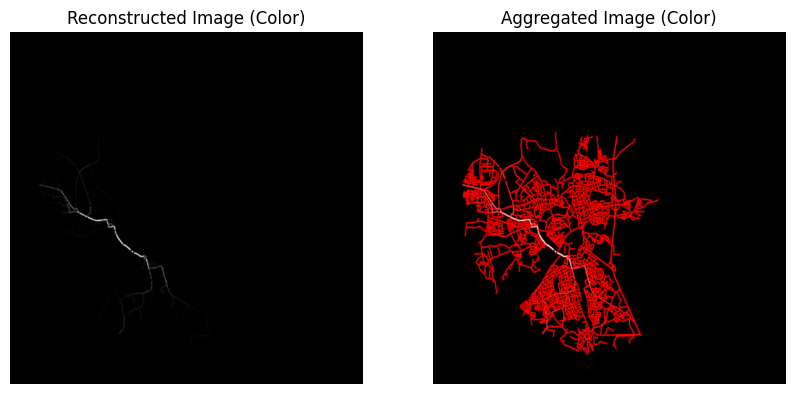

Aggregated image saved at aggregated_images\aggregated_image_10.png


In [30]:
# Load and prepare the map_plot image as a tensor
map_plot_path = 'map_plot/map_plot.png'

# Load the map_plot image in RGB (color)
map_plot_image = Image.open(map_plot_path).convert('RGB')  # Preserve color
map_plot_tensor = transforms.ToTensor()(map_plot_image)
map_plot_tensor = transforms.Resize((image_size, image_size))(map_plot_tensor)

from PIL import Image
import os

def plot_and_save_aggregated_image(model, dataset, map_plot_tensor, image_index=None, save_path='aggregated_images'):
    """
    Plot the reconstructed image and its multiplication with map_plot in color,
    then save the multiplied image to a specified folder.
    """
    model.eval()

    # Select a random index if not provided
    if image_index is None:
        image_index = random.randint(0, len(dataset) - 1)

    # Retrieve and preprocess the image
    img, _ = dataset[image_index]
    img = img.view(1, -1).to(device)

    # Reconstruct the image using the VAE
    with torch.no_grad():
        reconstructed_img, _, _ = model(img)

    # Reshape the reconstructed image to RGB
    reconstructed_img_np = reconstructed_img.view(image_size, image_size).cpu().numpy()
    reconstructed_img_rgb = np.stack([reconstructed_img_np] * 3, axis=-1)  # Duplicate channels for RGB

    # Convert the map_plot to a numpy array
    map_plot_np = map_plot_tensor.permute(1, 2, 0).cpu().numpy()

    # Multiply each channel independently
    multiplied_result = reconstructed_img_rgb + map_plot_np

    # Plot the reconstructed and multiplied images side-by-side in color
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Reconstructed Image in Color
    axes[0].imshow(reconstructed_img_rgb)
    axes[0].axis('off')
    axes[0].set_title("Reconstructed Image (Color)")

    # Multiplied Image in Color
    axes[1].imshow(multiplied_result)
    axes[1].axis('off')
    axes[1].set_title("Aggregated Image (Color)")

    plt.show()

    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)

    # Save the multiplied image
    multiplied_image = Image.fromarray((multiplied_result * 255).astype(np.uint8))
    multiplied_image_path = os.path.join(save_path, f'aggregated_image_{image_index}.png')
    multiplied_image.save(multiplied_image_path)
    print(f"Aggregated image saved at {multiplied_image_path}")

# Use the function
plot_and_save_aggregated_image(model, route_dataset, map_plot_tensor, image_index=10)